In [1]:
%load_ext autoreload
%autoreload 2
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AdamW
from transformers import AutoModel, BertTokenizerFast
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
from process_data import *
from models.transformer_cnn import *
from training import train
from evaluation import evaluate
import matplotlib.pyplot as plt

In [2]:
df_zoo_train, df_zoo_test = load_data("../data")
df_zoo_train.head()

,Record_id,Attribute_name,y_act,total_vals,num_nans,%_nans,num_of_dist_val,%_dist_val,mean,std_dev,...,mean_stopword_total,stdev_stopword_total,mean_char_count,stdev_char_count,mean_whitespace_count,stdev_whitespace_count,mean_delim_count,stdev_delim_count,is_list,is_long_sentence
0,33,Area,categorical,21477,0,0.0,174,0.810169,0.000000,0.000000,...,0.2,0.4,10.0,4.816638,0.4,0.8,0.4,0.8,False,False
1,33,Area Code,categorical,21477,0,0.0,174,0.810169,125.449411,72.866452,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,False,False
2,33,Element,categorical,21477,0,0.0,2,0.009312,0.000000,0.000000,...,0.0,0.0,4.0,0.000000,0.0,0.0,0.0,0.0,False,False
3,33,Element Code,categorical,21477,0,0.0,2,0.009312,5211.687154,146.816661,...,0.0,0.0,4.0,0.000000,0.0,0.0,0.0,0.0,False,False
4,33,Item,categorical,21477,0,0.0,115,0.535457,0.000000,0.000000,...,0.8,0.4,19.6,2.244994,2.0,0.0,2.0,0.0,False,False


In [3]:
train_data = preprocess(df_zoo_train, " </s> ")
test_data = preprocess(df_zoo_test, " </s> ")
train_data.head()

,text,features,label
0,Area </s> Afghanistan </s> Albania </s> Algeri...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
1,Area Code </s> 2 </s> 3 </s> 4 </s> 7 </s> 8,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
2,Element </s> Food </s> Feed </s> Food </s> Foo...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
3,Element Code </s> 5142 </s> 5521 </s> 5142 </s...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
4,Item </s> Wheat and products </s> Rice (Milled...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0


In [4]:
x_train, x_val, y_train, y_val = train_test_split(train_data[['text', "features"]], train_data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=train_data['label'])

In [5]:
transformer = AutoModel.from_pretrained('xlm-roberta-base')

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
model_name = "xlm_roberta_cnn_v1"

In [7]:
device = torch.device("cuda")

In [8]:
for param in transformer.parameters():
    param.requires_grad = False

In [9]:
train_dataloader, val_dataloader, test_dataloader = init_dataloaders(x_train, y_train, x_val, y_val,
                                                                          test_data, model="xlm-roberta")

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/home/tamittal/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2198: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
model = Transformer_cnn(transformer, 256, [2, 3, 4])

model = model.to(device)

In [12]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
print("Class Weights:",class_weights)

Class Weights: [0.3034519  0.47585845 1.64387464 3.05291005 7.66545894 1.88059259
 4.63961988 1.00890161 1.25261496]


/home/tamittal/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8.], y=7476    6.0
1834    1.0
7213    5.0
500     0.0
1015    7.0
       ... 
2251    0.0
3105    2.0
5948    8.0
1403    1.0
357     0.0
Name: label, Length: 6347, dtype: float64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [13]:
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

In [14]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

In [26]:
# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-6)
# number of training epochs
epochs = 10

In [27]:
#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _, = train(model, train_dataloader, optimizer, cross_entropy)
    
    #evaluate model
    valid_loss, _, valid_acc = evaluate(model, val_dataloader, cross_entropy, y_val)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '../models/exports/%s.pt' % model_name)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')


 Epoch 1 / 10
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.326
Validation Loss: 0.521
Validation Accuracy: 0.825

 Epoch 2 / 10
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.321
Validation Loss: 0.521
Validation Accuracy: 0.825

 Epoch 3 / 10
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.320
Validation Loss: 0.521
Validation Accuracy: 0.826

 Epoch 4 / 10
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.326
Validation Loss: 0.521
Validation Accuracy: 0.827

 Epoch 5 / 10
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.319
Validation Loss: 0.522
Validation Accuracy: 0.825

 Epoch 6 / 10
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evalua

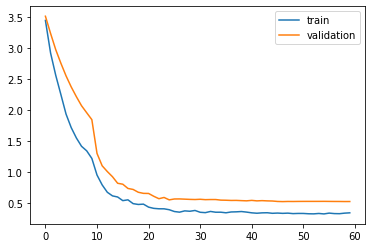

In [28]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train", "validation"])

In [29]:
loss, preds, acc = evaluate(model, test_dataloader, cross_entropy, test_data["label"])
print("test_accuracy:", acc)


Evaluating...
  Batch    50  of     63.
test_accuracy: 0.818639798488665
